# Predicting sales using PyTorch

####  This script is for forecasting sales using a neural network implemented in PyTorch
*This approach uses a neural network model implemented in PyTorch to forecast sales based on historical data. The model is trained using features such as order date, ship mode, segment, etc., and the target variable is sales. The results achieved are evaluated using RMSE, and the actual vs predicted sales are visualized for interpretation.*

### 1. Importing Libraries
- Importing necessary libraries such as Pandas for data manipulation, Matplotlib for plotting, PyTorch for building and training neural networks, and scikit-learn for data preprocessing and splitting.

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

### 2. Setting Path and Creating Dataframes:
- Setting the path to the input file and creating dataframes from the CSV file.

In [2]:
# Setting path to input files
file = "Super_Sales.csv"

In [3]:
# Creating dataframes
data = pd.read_csv(file)
df = pd.DataFrame(data)

### 3. Preprocessing the Data:

- Converting date columns to datetime format.
- Encoding categorical features using LabelEncoder.
- Extracting features like year, month, and day from the date.

In [4]:
# Load your DataFrame
df = pd.DataFrame(data)

# Preprocess the data
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day

### 4. Defining Features and Target:
- Defining features and target variable.
- Including 'Order Date' in the test set for later plotting.

In [5]:
# Encode categorical features
label_encoders = {}
for column in ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Define features and target
features = ['Order Year', 'Order Month', 'Order Day', 'Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']
X = df[features]
y = df['Sales']

# Include 'Order Date' in the test set
X['Order Date'] = df['Order Date']

/var/folders/d4/7m9sw_1j7xs95mzgw84z3bp00000gn/T/ipykernel_24865/3060367494.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Order Date'] = df['Order Date']


### 5. Splitting Data and Scaling Features and Createing Tensors:

- Splitting the data into training and testing sets.
- Standardizing the features using StandardScaler.
- Converting the data into PyTorch tensors for model training.


In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate 'Order Date' for plotting
X_test_dates = X_test['Order Date']
X_train = X_train.drop(columns='Order Date')
X_test = X_test.drop(columns='Order Date')

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

### 6. Defining the Neural Network:
- Defining a neural network model with dropout layers for regularization.

In [7]:
# Define the neural network with dropout for regularization
class SalesPredictor(nn.Module):
    def __init__(self, input_dim):
        super(SalesPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

### 7. Initializing Model, Loss Function, and Optimizer:
- Initializing the model, loss function (Mean Squared Error), and optimizer (Adam).


In [8]:
# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
model = SalesPredictor(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [10/300], Train Loss: 371961.1875, Validation Loss: 740775.5000
Epoch [20/300], Train Loss: 371501.0625, Validation Loss: 740174.3750
Epoch [30/300], Train Loss: 370455.3125, Validation Loss: 738797.6875
Epoch [40/300], Train Loss: 368313.1562, Validation Loss: 736015.3750
Epoch [50/300], Train Loss: 364379.8125, Validation Loss: 730906.0000
Epoch [60/300], Train Loss: 357865.9688, Validation Loss: 722402.3125
Epoch [70/300], Train Loss: 348390.4062, Validation Loss: 709768.4375
Epoch [80/300], Train Loss: 336309.1562, Validation Loss: 693700.1875
Epoch [90/300], Train Loss: 326039.3750, Validation Loss: 677803.8125
Epoch [100/300], Train Loss: 320696.4688, Validation Loss: 667559.3125
Epoch [110/300], Train Loss: 319824.1875, Validation Loss: 663803.2500
Epoch [120/300], Train Loss: 320014.3125, Validation Loss: 662949.8750
Epoch [130/300], Train Loss: 318269.2812, Validation Loss: 662922.3125
Epoch [140/300], Train Loss: 317562.3125, Validation Loss: 662188.8125
Epoch [150/300]

### 8. Training Loop with Early Stopping:

- Training the model with a training loop that includes early stopping based on validation loss.
- If the validation loss does not improve for a certain number of epochs (patience), training is stopped early to prevent overfitting.


In [11]:
# Training loop with early stopping
epochs = 300
patience = 20
best_loss = float('inf')
counter = 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        best_model = model.state_dict()
    else:
        counter += 1
        
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
        
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

TypeError: 'int' object is not callable

### 9. Loading the Best Model and Evaluating:
- Loading the best model based on the validation loss.
- Evaluating the model on the test data to compute the Root Mean Squared Error (RMSE).


In [9]:
# Load the best model
model.load_state_dict(best_model)

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(predictions, y_test)
    rmse = torch.sqrt(mse)
    pytorch_rmse_4 = rmse.item()
    print(f'Root Mean Squared Error on Test Data: {pytorch_rmse_4:.4f}')

Root Mean Squared Error on Test Data: 800.3060


### 10. Plotting the Results:

- Plotting the actual vs predicted sales over the years using Matplotlib.

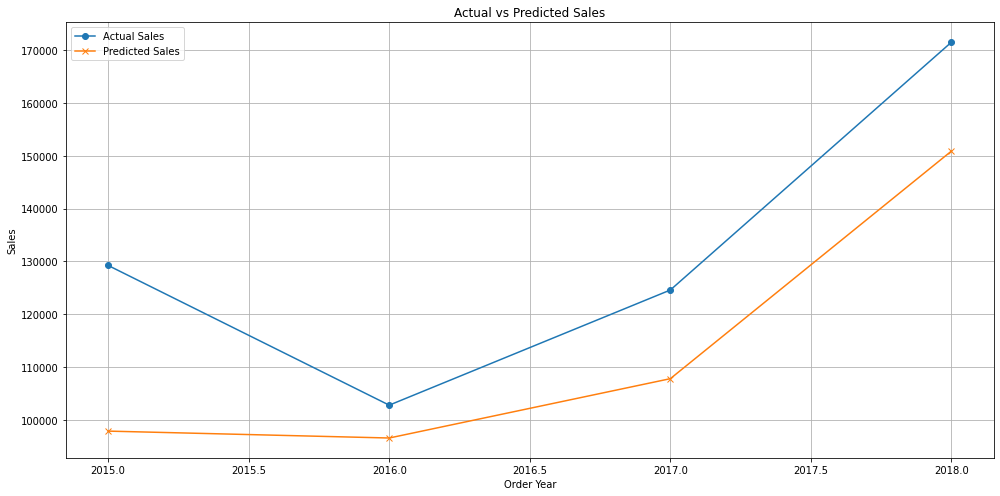

In [10]:
# Prepare data for plotting
predictions = predictions.numpy().flatten()
y_test = y_test.numpy().flatten()
results_df = pd.DataFrame({'Order Date': X_test_dates, 'Actual Sales': y_test, 'Predicted Sales': predictions})
results_df['Order Year'] = results_df['Order Date'].dt.year

# Group by year and sum sales
grouped_results = results_df.groupby('Order Year').sum().reset_index()

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(grouped_results['Order Year'], grouped_results['Actual Sales'], label='Actual Sales', marker='o')
plt.plot(grouped_results['Order Year'], grouped_results['Predicted Sales'], label='Predicted Sales', marker='x')
plt.xlabel('Order Year')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()